In [23]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D, Flatten, Conv1D, \
                                    Conv2D, BatchNormalization, MaxPooling1D, \
                                    GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, ELU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Rock vs Instrumental

In [2]:
META_DIR = Path('../data/fma_metadata')
AUDIO_DIR = Path('../data/fma_small')
CONVERTED_DIR = Path('../data/converted/rock_inst')

In [52]:
def show_summary_stats(history, dpi=100):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.figure(figsize=(4,3), dpi=dpi)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

    # Summarize history for loss
    plt.figure(figsize=(4,3), dpi=dpi)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [4]:
genre_dict = {'Rock': 0, 'Instrumental': 1}

reverse_map = {v: k for k, v in genre_dict.items()}
print(reverse_map)

{0: 'Rock', 1: 'Instrumental'}


In [5]:
npzfile = np.load(CONVERTED_DIR/'train_arr.npz')
X_train = npzfile['X']
y_train = npzfile['y']
print(X_train.shape, y_train.shape)

(1599, 640, 128) (1599,)


In [6]:
npzfile = np.load(CONVERTED_DIR/'valid_arr.npz')
X_valid = npzfile['X']
y_valid = npzfile['y']
print(X_valid.shape, y_valid.shape)

(200, 640, 128) (200,)


In [8]:
# Add dimension for single channel for Conv2D
X_train = X_train[...,None] / -80
X_valid = X_valid[...,None] / -80

In [9]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [32]:
# Build model
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape = (640, 128, 1), 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 2, activation = 'softmax'))

opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 640, 128, 32)      832       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 320, 64, 32)       0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 320, 64, 32)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 318, 62, 64)       18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 318, 62, 128)      8320      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 128)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)              

In [35]:
checkpoint_callback = ModelCheckpoint('../models/model2_best.h5', monitor='val_accuracy', verbose=1,
                                      save_best_only=True, mode='max')

reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, 
                                      patience=6, min_delta=0.01, verbose=1)

callbacks_list = [checkpoint_callback, reducelr_callback]

In [36]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50,
                    validation_data=(X_valid, y_valid), verbose=1, 
                    callbacks=callbacks_list)


Train on 1599 samples, validate on 200 samples
Epoch 1/50
1536/1599 [===========================>..] - ETA: 0s - loss: 0.6890 - accuracy: 0.4922
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ../models/model2_best.h5
1599/1599 [==============================] - 17s 11ms/sample - loss: 0.6894 - accuracy: 0.4891 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 2/50
1536/1599 [===========================>..] - ETA: 0s - loss: 0.6762 - accuracy: 0.5039
Epoch 00002: val_accuracy did not improve from 0.50000
1599/1599 [==============================] - 13s 8ms/sample - loss: 0.6765 - accuracy: 0.5022 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 3/50
1536/1599 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.5078
Epoch 00003: val_accuracy improved from 0.50000 to 0.50500, saving model to ../models/model2_best.h5
1599/1599 [==============================] - 13s 8ms/sample - loss: 0.6693 - accuracy: 0.5078 - val_loss: 0.6763 - val_accuracy: 0.5

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


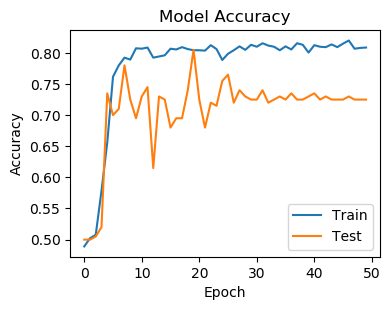

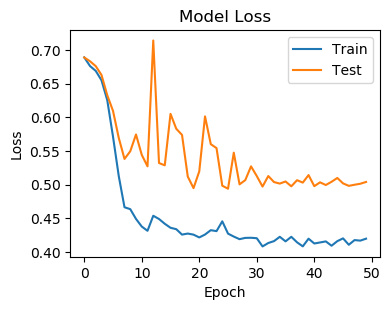

In [53]:
show_summary_stats(history)

# Model from blog
https://github.com/priya-dwivedi/Music_Genre_Classification/blob/master/CRNN_model.ipynb

In [80]:
# Reload train and test
npzfile = np.load(CONVERTED_DIR/'train_arr.npz')
X_train = npzfile['X']
y_train = npzfile['y']

npzfile = np.load(CONVERTED_DIR/'valid_arr.npz')
X_valid = npzfile['X']
y_valid = npzfile['y']


In [81]:
# Normalize
X_train = X_train / -80
X_valid = X_valid / -80

In [82]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [83]:
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [84]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [85]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('../models/crnn_weights_best.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, 
                                          patience=10, min_delta=0.01, verbose=1)
    
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, 
                        callbacks=callbacks_list)

    return model, history


In [86]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 128)]       0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 56)          224       
_________________________________________________________________
activation_12 (Activation)   (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 56)          0         
_________________________________________________________________
dropout_46 (Dropout)         (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None,

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


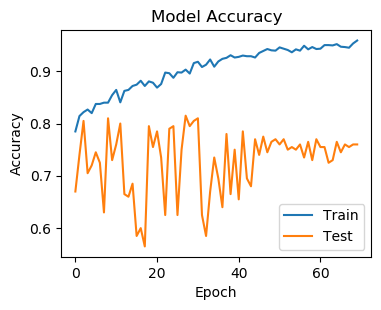

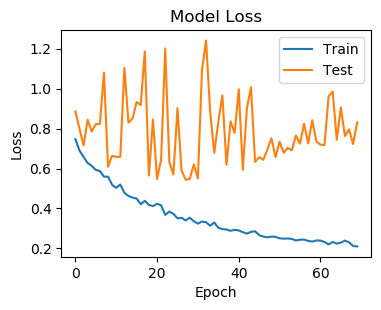

In [89]:
show_summary_stats(history)